# Data Augmentation

Why did I use data augmentation?

Since this is a small dataset, There wasn't enough examples to train the neural network. Also, data augmentation was useful in taclking the data imbalance issue in the data.

Further explanations are found in the Data Augmentation notebook.

Before data augmentation, the dataset consisted of:
155 positive and 98 negative examples, resulting in 253 example images.

After data augmentation, now the dataset consists of:
1085 positive and 980 examples, resulting in 2065 example images.

Note: these 2065 examples contains also the 253 original images. They are found in folder named 'augmented data'.

In [3]:
!pip install imutils

In [4]:
import numpy as np
import pandas as pd
import os
import time
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [5]:
image_dir="/content/brain-mri-images-for-brain-tumor-detection/"

In [6]:
os.makedirs('/content/brain-mri-images-for-brain-tumor-detection/output/augmented')
os.makedirs('/content/brain-mri-images-for-brain-tumor-detection/output/augmented/yes')
os.makedirs('/content/brain-mri-images-for-brain-tumor-detection/output/augmented/no')

In [13]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [14]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
start_time = time.time()

augmented_data_path ='/content/brain-mri-images-for-brain-tumor-detection/output/augmented/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

KeyboardInterrupt: ignored

In [16]:
def data_summary(main_path):

    yes_path = main_path+'yes'
    no_path = main_path+'no'

    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)

    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")
data_summary(augmented_data_path)

Number of examples: 518
Percentage of positive examples: 100.0%, number of pos examples: 518
Percentage of negative examples: 0.0%, number of neg examples: 0


# Data Preprocessing

For every image, the following preprocessing steps were applied:

1. Crop the part of the image that contains only the brain (which is the most important part of the image).
2. Resize the image to have a shape of (240, 240, 3)=(image_width, image_height, number of channels): because images in the dataset come in different sizes. So, all images should have the same shape to feed it as an input to the neural network.
3. Apply normalization: to scale pixel values to the range 0-1.

In [17]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

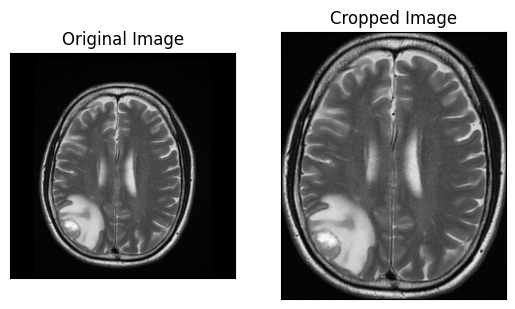

In [18]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [19]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [20]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 518
X shape is: (518, 240, 240, 3)
y shape is: (518, 1)


In [21]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

<Figure size 1000x800 with 0 Axes>

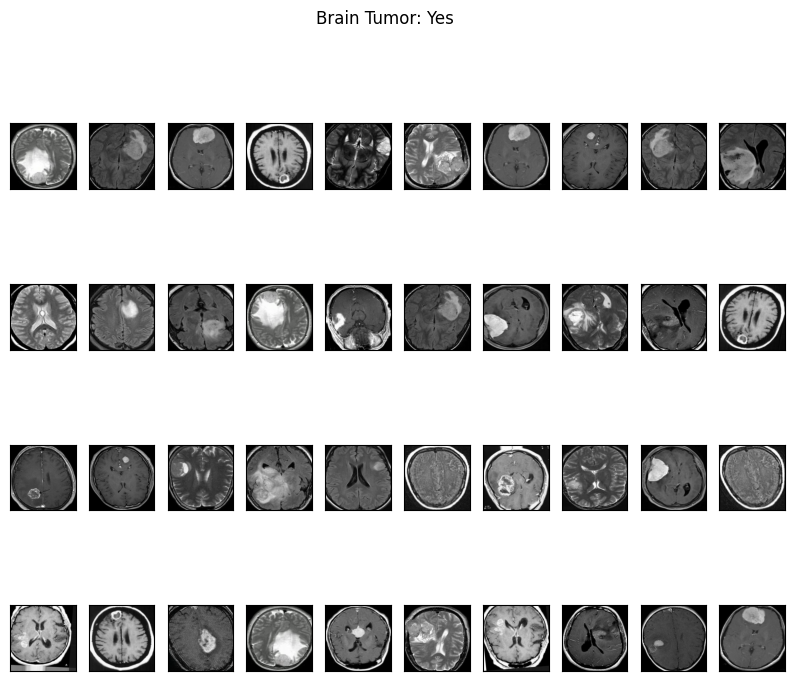

In [22]:
plot_sample_images(X, y)

In [23]:
def data_summary(main_path):

    yes_path = main_path+'yes'
    no_path = main_path+'no'

    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)

    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")
data_summary(augmented_data_path)

Number of examples: 518
Percentage of positive examples: 100.0%, number of pos examples: 518
Percentage of negative examples: 0.0%, number of neg examples: 0


In [24]:
!pip install pycocotools

In [25]:
import os
import re
import sys
import cv2
import glob
import time
import json
import math
import random
import imutils
import itertools
import matplotlib
import numpy as np # linear algebra
import skimage.draw
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from imgaug import augmenters as iaa

from IPython.display import clear_output

In [26]:
!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 24.19 MiB/s, done.
Resolving deltas: 100% (558/558), done.


# Data Split:

# New section

The data was split in the following way:

1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [27]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


In [29]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 362
number of development examples = 78
number of test examples = 78
X_train shape: (362, 240, 240, 3)
Y_train shape: (362, 1)
X_val (dev) shape: (78, 240, 240, 3)
Y_val (dev) shape: (78, 1)
X_test shape: (78, 240, 240, 3)
Y_test shape: (78, 1)


In [30]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [31]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape.
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [32]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [33]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


In [36]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [37]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))


In [41]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/100
12/12 [==============================] - 15s 1s/step - loss: 3.6745e-11 - accuracy: 1.0000 - val_loss: 1.4221e-09 - val_accuracy: 1.0000
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 5.4501e-11 - accuracy: 1.0000 - val_loss: 1.1236e-09 - val_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 5.0479e-11 - accuracy: 1.0000 - val_loss: 9.0311e-10 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 4.7308e-11 - accuracy: 1.0000 - val_loss: 7.3769e-10 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 16s 1s/step - loss: 4.7597e-11 - accuracy: 1.0000 - val_loss: 6.0420e-10 - val_accuracy: 1.0000
Epoch 6/100
 7/12 [================>.............] - ETA: 6s - loss: 1.4061e-11 - accuracy: 1.0000

KeyboardInterrupt: ignored

# New section